In [ ]:
from google.colab import files
#files.upload()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "drive/My Drive/Colab Notebooks/Tabular/StockPricePrediction/inputs/"
!ls "drive/My Drive/Colab Notebooks/Tabular/StockPricePrediction/inputs/"

SampleSubmission.csv  Test.csv	Train.csv


In [ ]:
ss = pd.read_csv(path+'SampleSubmission.csv')
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')

In [ ]:
ID_COL, TARGET_COL = 'id', 'Close'
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 73439 samples and 9 variables

Test contains 4223 samples and 5 variables

The dataset contains 8 features


In [ ]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

In [ ]:
traintmp = train.copy()
testtmp = test.copy()

In [ ]:
traintmp["day_diffhl"] = traintmp["High"] - traintmp["Low"]
traintmp["day_diff"] = traintmp["Close"] - traintmp["Open"]

traintmp["Previous_day"] = traintmp.groupby('stock')['Close'].shift(1)
traintmp["Previous_week"] = traintmp.groupby('stock')['Close'].shift(5)
traintmp["Previous_month"] = traintmp.groupby('stock')['Close'].shift(30)

for i in [14,30,60]:
    print('Rolling period:', i)
    traintmp['rolling_mean_'+str(i)] = traintmp.groupby(['stock'])['Close'].transform(lambda x: x.shift(1).rolling(i).mean())
    traintmp['rolling_std_'+str(i)]  = traintmp.groupby(['stock'])['Close'].transform(lambda x: x.shift(1).rolling(i).std())

Rolling period: 14
Rolling period: 30
Rolling period: 60


In [ ]:
# Aggregate
grouped_df = traintmp.groupby(['stock'])['rolling_mean_60'].agg(["mean"]).reset_index()
grouped_df.columns = ['stock','stock_mean_rolling_std_60']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['rolling_mean_30'].agg(["mean"]).reset_index()
grouped_df.columns = ['stock','stock_mean_rolling_std_30']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['rolling_mean_14'].agg(["mean"]).reset_index()
grouped_df.columns = ['stock','stock_mean_rolling_std_14']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['Previous_day'].agg(["std","mean","skew"]).reset_index()
grouped_df.columns = ['stock','stock_std_pd','stock_mean_pd','stock_skew_pd']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['Previous_week'].agg(["std","mean","skew"]).reset_index()
grouped_df.columns = ['stock','stock_std_pw','stock_mean_pw','stock_skew_pw']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['Previous_month'].agg(["std","mean","skew"]).reset_index()
grouped_df.columns = ['stock','stock_std_pm','stock_mean_pm','stock_skew_pm']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['Close'].agg(["min","max","std","mean","skew"]).reset_index()
grouped_df.columns = ['stock','stock_min','stock_max','stock_std','stock_mean','stock_skew']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['day_diffhl'].agg(["min","max","std","mean","skew"]).reset_index()
grouped_df.columns = ['stock','stock_day_diffhl_min','stock_day_diffhl_max','stock_day_diffhl_std','stock_day_diffhl_mean','stock_day_diffhl_skew']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

grouped_df = traintmp.groupby(['stock'])['day_diff'].agg(["std","mean","skew"]).reset_index()
grouped_df.columns = ['stock','stock_day_diff_std','stock_day_diff_mean','stock_day_diff_skew']
traintmp = pd.merge(traintmp, grouped_df, how="left", on=['stock'])
testtmp = pd.merge(testtmp, grouped_df, how="left", on=['stock'])

In [ ]:
traintmp.columns

Index(['ID', 'stock', 'Date', 'Open', 'High', 'Low', 'Close', 'holiday',
       'unpredictability_score', 'day_diffhl', 'day_diff', 'Previous_day',
       'Previous_week', 'Previous_month', 'rolling_mean_14', 'rolling_std_14',
       'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60',
       'rolling_std_60', 'stock_mean_rolling_std_60',
       'stock_mean_rolling_std_30', 'stock_mean_rolling_std_14',
       'stock_std_pd', 'stock_mean_pd', 'stock_skew_pd', 'stock_std_pw',
       'stock_mean_pw', 'stock_skew_pw', 'stock_std_pm', 'stock_mean_pm',
       'stock_skew_pm', 'stock_min', 'stock_max', 'stock_std', 'stock_mean',
       'stock_skew', 'stock_day_diffhl_min', 'stock_day_diffhl_max',
       'stock_day_diffhl_std', 'stock_day_diffhl_mean',
       'stock_day_diffhl_skew', 'stock_day_diff_std', 'stock_day_diff_mean',
       'stock_day_diff_skew'],
      dtype='object')

In [ ]:
newcols = ['stock_std_pd', 'stock_mean_pd', 'stock_skew_pd', 'stock_std_pw',
       'stock_mean_pw', 'stock_skew_pw', 'stock_std_pm', 'stock_mean_pm',
       'stock_skew_pm', 'stock_min', 'stock_max', 'stock_std', 'stock_mean',
       'stock_skew', 'stock_day_diffhl_min', 'stock_day_diffhl_max',
       'stock_day_diffhl_std', 'stock_day_diffhl_mean',
       'stock_day_diffhl_skew', 'stock_day_diff_std', 'stock_day_diff_mean',
       'stock_day_diff_skew']
datevars = ['Is_quarter_end', 'Is_month_end', 'Is_year_start', 'Dayofweek', 'Is_quarter_start', 
            'Is_month_start', 'Month', 'Day', 'Year', 'Week', 'Is_year_end']
cat_vars=['stock','holiday','unpredictability_score']
features = cat_vars + newcols

In [ ]:
train = traintmp[features + ['Date','Close']]
test = testtmp[features + ['Date']]

In [ ]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)

In [ ]:
import matplotlib.pyplot as plt
import PIL
import json
from fastai import *
from fastai.tabular import * 

from datetime import datetime

In [ ]:
add_datepart(df, "Date", drop=False)

,stock,holiday,unpredictability_score,stock_std_pd,stock_mean_pd,stock_skew_pd,stock_std_pw,stock_mean_pw,stock_skew_pw,stock_std_pm,stock_mean_pm,stock_skew_pm,stock_min,stock_max,stock_std,stock_mean,stock_skew,stock_day_diffhl_min,stock_day_diffhl_max,stock_day_diffhl_std,stock_day_diffhl_mean,stock_day_diffhl_skew,stock_day_diff_std,stock_day_diff_mean,stock_day_diff_skew,Date,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,1,7,9.672890,95.914417,0.871011,9.562537,95.792450,0.879694,8.748125,94.991033,0.886438,78.7790,120.7250,9.701546,95.945449,0.869184,-0.7096,3.5369,0.622068,0.229498,1.798620,0.813480,0.059232,-0.529209,2017-01-03,82.8101,2017,1,1,3,1,3,False,False,False,False,False,False,1483401600
1,0,0,7,9.672890,95.914417,0.871011,9.562537,95.792450,0.879694,8.748125,94.991033,0.886438,78.7790,120.7250,9.701546,95.945449,0.869184,-0.7096,3.5369,0.622068,0.229498,1.798620,0.813480,0.059232,-0.529209,2017-01-04,82.9690,2017,1,1,4,2,4,False,False,False,False,False,False,1483488000
2,0,0,7,9.672890,95.914417,0.871011,9.562537,95.792450,0.879694,8.748125,94.991033,0.886438,78.7790,120.7250,9.701546,95.945449,0.869184,-0.7096,3.5369,0.622068,0.229498,1.798620,0.813480,0.059232,-0.529209,2017-01-05,82.8578,2017,1,1,5,3,5,False,False,False,False,False,False,1483574400
3,0,0,7,9.672890,95.914417,0.871011,9.562537,95.792450,0.879694,8.748125,94.991033,0.886438,78.7790,120.7250,9.701546,95.945449,0.869184,-0.7096,3.5369,0.622068,0.229498,1.798620,0.813480,0.059232,-0.529209,2017-01-06,82.7385,2017,1,1,6,4,6,False,False,False,False,False,False,1483660800
4,0,0,7,9.672890,95.914417,0.871011,9.562537,95.792450,0.879694,8.748125,94.991033,0.886438,78.7790,120.7250,9.701546,95.945449,0.869184,-0.7096,3.5369,0.622068,0.229498,1.798620,0.813480,0.059232,-0.529209,2017-01-09,81.8641,2017,1,2,9,0,9,False,False,False,False,False,False,1483920000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77657,102,0,6,8.011921,132.468919,0.038861,8.034250,132.473676,0.036986,8.130333,132.629856,-0.012336,116.6759,149.0492,8.006555,132.466488,0.039783,-1.6316,5.0247,0.844920,-0.374612,1.615917,0.945031,0.100689,-0.811934,2019-12-24,NaN,2019,12,52,24,1,358,False,False,False,False,False,False,1577145600
77658,102,1,6,8.011921,132.468919,0.038861,8.034250,132.473676,0.036986,8.130333,132.629856,-0.012336,116.6759,149.0492,8.006555,132.466488,0.039783,-1.6316,5.0247,0.844920,-0.374612,1.615917,0.945031,0.100689,-0.811934,2019-12-26,NaN,2019,12,52,26,3,360,False,False,False,False,False,False,1577318400
77659,102,0,6,8.011921,132.468919,0.038861,8.034250,132.473676,0.036986,8.130333,132.629856,-0.012336,116.6759,149.0492,8.006555,132.466488,0.039783,-1.6316,5.0247,0.844920,-0.374612,1.615917,0.945031,0.100689,-0.811934,2019-12-27,NaN,2019,12,52,27,4,361,False,False,False,False,False,False,1577404800
77660,102,0,6,8.011921,132.468919,0.038861,8.034250,132.473676,0.036986,8.130333,132.629856,-0.012336,116.6759,149.0492,8.006555,132.466488,0.039783,-1.6316,5.0247,0.844920,-0.374612,1.615917,0.945031,0.100689,-0.811934,2019-12-30,NaN,2019,12,1,30,0,364,False,False,False,False,False,False,1577664000


In [ ]:
train, test = df[:train.shape[0]].reset_index(drop = True), df[train.shape[0]:].reset_index(drop = True)

In [ ]:
null_values_per_variable = 100 * (test.isnull().sum()/test.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Close                     100.0
Elapsed                   0.0  
stock_day_diffhl_max      0.0  
stock_skew                0.0  
stock_mean                0.0  
stock_std                 0.0  
stock_max                 0.0  
stock_min                 0.0  
stock_skew_pm             0.0  
stock_mean_pm             0.0  
stock_std_pm              0.0  
stock_skew_pw             0.0  
stock_mean_pw             0.0  
stock_std_pw              0.0  
stock_skew_pd             0.0  
stock_mean_pd             0.0  
stock_std_pd              0.0  
unpredictability_score    0.0  
holiday                   0.0  
stock_day_diffhl_min      0.0  
stock_day_diffhl_std      0.0  
Is_year_start             0.0  
Day                       0.0  
Is_year_end               0.0  
Is_quarter_start          0.0  
Is_quarter_end            0.0  
Is_month_start            0.0  
Is_month_end              0.0  
Dayofyear                 0.0  
Dayofweek                 0.0  
Week                      0.0  
stock_da

In [ ]:
LAST_TRAINING_DAY = train['Date'].max()
DAYS_TO_VALIDATE = pd.Timedelta(days = 45)
VAL_FIRST_DAY = LAST_TRAINING_DAY - DAYS_TO_VALIDATE
LAST_TRAINING_DAY - VAL_FIRST_DAY

Timedelta('45 days 00:00:00')

In [ ]:
val_fltr = train['Date'] >= VAL_FIRST_DAY
trn, val = train[~val_fltr].reset_index(drop = True), train[val_fltr].reset_index(drop = True)

In [ ]:
trn.fillna(0,inplace=True)
val.fillna(0,inplace=True)

In [ ]:
train['Week_of_year'] = train['Date'].dt.week
test['Week_of_year'] = test['Date'].dt.week

train['days_diff_from_today'] = (test.Date.max() - train['Date']).dt.days
test['days_diff_from_today'] = (test.Date.max() - test['Date']).dt.days

In [ ]:
# Import one more package:
from calendar import monthrange

# Define a function to get end of the month:
def last_day_of_month(date_value):
    return date_value.replace(day = monthrange(date_value.year, date_value.month)[1])
    
# Calculate the number of days to end of the month:
train['days_to_end_of_the_month'] = train['Date'].apply(lambda x: (last_day_of_month(x) - x).days)
test['days_to_end_of_the_month'] = test['Date'].apply(lambda x: (last_day_of_month(x) - x).days)


In [ ]:
train['quarter'] = train['Date'].dt.quarter
test['quarter'] = test['Date'].dt.quarter

In [ ]:
train["DayCount"] = train["Date"].apply(lambda x: x.toordinal())
test["DayCount"] = test["Date"].apply(lambda x: x.toordinal())

In [ ]:
val_fltr = train['Date'] >= VAL_FIRST_DAY
trn, val = train[~val_fltr].reset_index(drop = True), train[val_fltr].reset_index(drop = True)

In [ ]:
import datetime
# VALSTART = datetime.datetime.strptime('01-01-2019', '%m-%d-%Y')
# VALEND = datetime.datetime.strptime('02-15-2019', '%m-%d-%Y')

# val_fltr = ((train['Date'] >= VALSTART) & (train['Date'] <= VALEND))
# trn, val = train[~val_fltr].reset_index(drop = True), train[val_fltr].reset_index(drop = True)

In [ ]:
newcols = ['stock_std_pd', 'stock_mean_pd', 'stock_skew_pd', 'stock_std_pw',
       'stock_mean_pw', 'stock_skew_pw', 'stock_std_pm', 'stock_mean_pm',
       'stock_skew_pm', 'stock_min', 'stock_max', 'stock_std', 'stock_mean',
       'stock_skew', 'stock_day_diffhl_min', 
       'stock_day_diffhl_std',  'stock_day_diff_std','DayCount',
       ]
datevars = ['Is_quarter_end', 'Is_month_end', 'Is_year_start', 'Dayofweek', 'Is_quarter_start', 
            'Is_month_start', 'Month', 'Day', 'Year', 'Week', 'Is_year_end']
cat_vars=['stock','holiday','unpredictability_score']
features = cat_vars + newcols

#'stock_day_diffhl_mean','stock_day_diffhl_skew','stock_day_diffhl_max', 'stock_day_diff_mean',       'stock_day_diff_skew'

In [ ]:
features = cat_vars + datevars + ['Week_of_year', 'days_diff_from_today', 'days_to_end_of_the_month','quarter'] + newcols
#features

### LGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
#features = ['stock', 'holiday', 'unpredictability_score', 'Year', 'Month', 'Day', 'Week', 'Dayofweek']
# trn_fltr = trn.Year > 2017
# val_fltr = val.Year > 2017
# trn, val = trn[trn_fltr].reset_index(drop = True), val[val_fltr].reset_index(drop = True)

In [ ]:
corrmat = train[features].corr() 
  
#f, ax = plt.subplots(figsize =(9, 8)) 
#sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 
m = ~(corrmat.mask(np.eye(len(corrmat), dtype=bool)).abs() > 0.85).any()
raw = corrmat.loc[m, m]
raw

,stock,holiday,unpredictability_score,Is_quarter_end,Is_month_end,Is_year_start,Dayofweek,Is_quarter_start,Is_month_start,Is_year_end
stock,1.000000e+00,-2.219034e-19,2.606291e-01,-2.450734e-20,7.076567e-20,NaN,2.324524e-21,3.948406e-19,-1.176133e-21,2.853160e-20
holiday,-2.219034e-19,1.000000e+00,-1.561849e-17,-1.855300e-02,1.842059e-02,NaN,-1.431557e-01,-1.855300e-02,6.044255e-02,-9.256937e-03
unpredictability_score,2.606291e-01,-1.561849e-17,1.000000e+00,5.669119e-18,-1.247339e-18,NaN,-4.285011e-18,2.803071e-16,-1.153694e-17,6.970350e-17
Is_quarter_end,-2.450734e-20,-1.855300e-02,5.669119e-18,1.000000e+00,3.940316e-01,NaN,-1.655529e-03,-5.641749e-03,-1.340230e-02,4.989455e-01
Is_month_end,7.076567e-20,1.842059e-02,-1.247339e-18,3.940316e-01,1.000000e+00,NaN,1.213855e-02,-1.431801e-02,-3.401325e-02,1.966003e-01
Is_year_start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dayofweek,2.324524e-21,-1.431557e-01,-4.285011e-18,-1.655529e-03,1.213855e-02,NaN,1.000000e+00,-9.555033e-02,1.924148e-02,-5.436704e-02
Is_quarter_start,3.948406e-19,-1.855300e-02,2.803071e-16,-5.641749e-03,-1.431801e-02,NaN,-9.555033e-02,1.000000e+00,4.209539e-01,-2.814925e-03
Is_month_start,-1.176133e-21,6.044255e-02,-1.153694e-17,-1.340230e-02,-3.401325e-02,NaN,1.924148e-02,4.209539e-01,1.000000e+00,-6.687015e-03
Is_year_end,2.853160e-20,-9.256937e-03,6.970350e-17,4.989455e-01,1.966003e-01,NaN,-5.436704e-02,-2.814925e-03,-6.687015e-03,1.000000e+00


In [ ]:
train.shape,test.shape,trn.shape,val.shape

((73439, 45), (4223, 45), (69937, 45), (3502, 45))

In [ ]:
from lightgbm import LGBMRegressor
clf = LGBMRegressor(boosting_type='gbdt',n_estimators=800,learning_rate=0.12,num_leaves=70,random_state =181920,
                    reg_alpha=0.03,min_child_samples=18,bagging_fraction=0.1,num_iterations=1000 )
clf.fit(trn[features], trn['Close'], eval_set = [(val[features], val[TARGET_COL])], verbose = 50, 
        early_stopping_rounds=200, eval_metric='rmse')

Training until validation scores don't improve for 200 rounds.
[50]	valid_0's l2: 15.8938	valid_0's rmse: 3.9867
[100]	valid_0's l2: 10.4591	valid_0's rmse: 3.23405
[150]	valid_0's l2: 9.91503	valid_0's rmse: 3.14881
[200]	valid_0's l2: 9.60113	valid_0's rmse: 3.09857
[250]	valid_0's l2: 9.58443	valid_0's rmse: 3.09587
[300]	valid_0's l2: 9.4735	valid_0's rmse: 3.07791
[350]	valid_0's l2: 9.51912	valid_0's rmse: 3.08531
[400]	valid_0's l2: 9.50555	valid_0's rmse: 3.08311
[450]	valid_0's l2: 9.4665	valid_0's rmse: 3.07677
[500]	valid_0's l2: 9.43828	valid_0's rmse: 3.07218
[550]	valid_0's l2: 9.30121	valid_0's rmse: 3.04979
[600]	valid_0's l2: 9.31057	valid_0's rmse: 3.05132
[650]	valid_0's l2: 9.30664	valid_0's rmse: 3.05068
[700]	valid_0's l2: 9.32292	valid_0's rmse: 3.05335
[750]	valid_0's l2: 9.30235	valid_0's rmse: 3.04998
Early stopping, best iteration is:
[569]	valid_0's l2: 9.27803	valid_0's rmse: 3.04599


LGBMRegressor(bagging_fraction=0.1, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.12,
              max_depth=-1, min_child_samples=18, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=800, n_jobs=-1,
              num_iterations=1000, num_leaves=70, objective=None,
              random_state=181920, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
import pandas as pd

def get_lgbm_varimp(model, train_columns, max_vars=50):    
    cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T
    cv_varimp_df.columns = ['feature_name', 'varimp']
    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)    
    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]        
    return cv_varimp_df

In [ ]:
get_lgbm_varimp(clf,trn.columns,50)

,feature_name,varimp
15,stock_mean,5923
0,stock,4061
35,Is_quarter_end,3745
12,stock_min,2847
20,stock_day_diffhl_mean,2190
10,stock_mean_pm,2109
19,stock_day_diffhl_std,2088
18,stock_day_diffhl_max,2067
33,Is_month_end,1938
32,Dayofyear,1779


In [ ]:
ptt = clf.predict(test[features])
ptt
#pt = scaler.inverse_transform(pt.reshape(-1, 1) )
#download_preds(pt, 'lightgbm_simple4.12.csv')

array([115.947733, 116.086593, 115.945328, 115.936348, ..., 134.119633, 133.813558, 130.738414, 130.780509])

In [ ]:
# Trained Params with the full training set
clf = LGBMRegressor(colsample_bytree= 0.47514618245249834, learning_rate= 0.2, min_child_samples= 20,
 min_child_weight=10.0, n_estimators= 1500, num_leaves=90, reg_alpha= 7,
 reg_lambda= 100,subsample= 0.4989593144444127,random_state =181920)
clf.fit(train[features], train['Close'], verbose = 50)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.47514618245249834, importance_type='split',
              learning_rate=0.2, max_depth=-1, min_child_samples=20,
              min_child_weight=10.0, min_split_gain=0.0, n_estimators=1500,
              n_jobs=-1, num_leaves=90, objective=None, random_state=181920,
              reg_alpha=7, reg_lambda=100, silent=True,
              subsample=0.4989593144444127, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
# pt = pt*1.028
# To Modify - Push up the estimates of high unpredictable stocks by little more
arrset1 = [1,  8, 15, 17, 23, 29, 40, 59, 63, 67, 81,10, 28, 35, 38, 43, 49, 53, 56, 61, 76,
                                            3,  14,  25,  30,  33,  37,  44,  77,  84, 100,
                                            2, 11, 20, 22, 31, 39, 68, 72, 73, 89]                                 

In [ ]:
pt = clf.predict(test[features])
pt

array([117.609314, 117.820458, 117.930661, 117.999235, ..., 129.013856, 128.994659, 127.606132, 127.419766])

In [ ]:
testplot = test
testplot['Close'] = pt
valf = testplot.loc[testplot['stock'].isin(arrset1)]['Close'] * 1.006
vals = testplot.loc[~testplot['stock'].isin(arrset1)]['Close'] * 1.028
testplot.loc[testplot['stock'].isin(arrset1),'Close'] = valf.values
testplot.loc[~testplot['stock'].isin(arrset1),'Close'] = vals.values
pt = testplot['Close'].values
pt

array([120.902375, 121.119431, 121.232719, 121.303214, ..., 132.626244, 132.606509, 131.179104, 130.98752 ])

In [ ]:
download_preds(pt, 'lightgbm_simple4.25.csv') # Single Score Adjusted

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

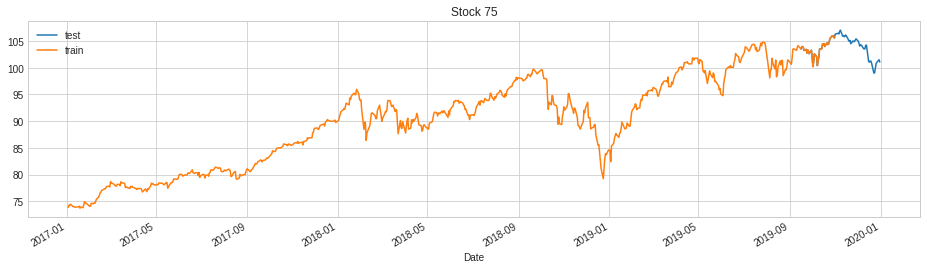

In [ ]:
STOCK_NO = 75

train_fltr = train['stock'] == STOCK_NO
train_tmp = train[train_fltr].set_index('Date')[['Close']]
train_tmp['type'] = 'train'

test_fltr = val['stock'] == STOCK_NO
test_tmp = val[test_fltr].set_index('Date')[['Close']]
test_tmp['type'] = 'test'

test_fltr = testplot['stock'] == STOCK_NO
testplot_tmp = testplot[test_fltr].set_index('Date')[['Close']]
testplot_tmp['type'] = 'test'

test_tmp = test_tmp.append(testplot_tmp)

_ = train_tmp.append(test_tmp).groupby('type')['Close'].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}', sharex=False)
_ = plt.legend()

In [ ]:
train.loc[train.unpredictability_score == 7].stock.unique()

array([ 0,  4, 18, 26, 47, 58, 65, 66, 75, 91])

In [ ]:
train.loc[train.unpredictability_score == 0].stock.unique()

array([ 1,  8, 15, 17, 23, 29, 40, 59, 63, 67, 81])

## Hyper Parameter Tunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': [50,70,90], 
             'min_child_samples': [10,15,20,22,18,25], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'n_estimators': [1000,1500,2000,3000],
             'learning_rate': [0.1,0.9,0.2,0.12,0.15],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
clf = LGBMRegressor(boosting_type='gbdt',n_estimators=1000,learning_rate=0.1,num_leaves=70,random_state =181920,
                    reg_alpha=0.01,min_child_samples=18)

In [ ]:
n_HP_points_to_test = 100
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,    
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
# %%time
# gs.fit(train2[features], train2['Close'],eval_set = [(val2[features], val2[TARGET_COL])], verbose = 50, 
#         early_stopping_rounds=500, eval_metric='rmse')
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

### XGB

In [ ]:
val_fltr = train['Date'] >= VAL_FIRST_DAY
trn, val = train[~val_fltr].reset_index(drop = True), train[val_fltr].reset_index(drop = True)

In [ ]:
# param_test ={'max_leaves': [50,70,90], 
#              'max_depth': [10,15,20,22,18,25], 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'n_estimators': [1000,1500,2000,3000],
#              'learning_rate': [0.1,0.9,0.2,0.12,0.15],
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
%%time
import xgboost as xgb
# model = xgb.XGBRegressor(max_depth=20,random_state =181920,
#                          objective='reg:linear',tree_method = 'hist',max_bin=100,
#                          early_stopping_rounds = 100)

# n_HP_points_to_test = 100
# gs = RandomizedSearchCV(
#     estimator=model, param_distributions=param_test, 
#     n_iter=n_HP_points_to_test,    
#     cv=3,
#     refit=True,
#     random_state=314,
#     verbose=True)

# gs.fit(train[features], train['Close'],eval_set = [(val[features], val[TARGET_COL])], verbose = 50, 
#         early_stopping_rounds=500, eval_metric='rmse')
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

CPU times: user 167 ms, sys: 5.02 ms, total: 172 ms
Wall time: 222 ms


In [ ]:

# model = xgb.XGBRegressor(learning_rate=0.12,max_depth=20,max_leaves=70,n_estimators=3000,random_state =181920,
#                          reg_alpha=0.03,min_child_samples=20,objective='reg:linear', num_boost_round = 626,
#                          min_child_weight=0.001,early_stopping_rounds = 100)

model = xgb.XGBRegressor(objective="reg:squarederror",colsample_bytree= 0.6859824186499318, learning_rate= 0.2,  max_depth= 20, max_leaves= 50,
  min_child_weight = 1000.0, n_estimators = 1000, reg_alpha = 7, reg_lambda= 100, subsample= 0.6078966452154348)

model.fit(train[features], train['Close'])
#print (model) , eval_set = [(val[features], val[TARGET_COL])]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6859824186499318, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=20, max_leaves=50, min_child_weight=1000.0, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=7,
             reg_lambda=100, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6078966452154348, verbosity=1)

In [ ]:
pt1 = model.predict(test[features])
pt1

array([118.04809 , 118.74486 , 118.93626 , 118.979004, ..., 131.45947 , 131.53522 , 131.31575 , 131.22818 ],
      dtype=float32)

In [ ]:
pt1 = pt1 *1.02
pt1

array([120.40905, 121.11975, 121.31498, 121.35858, ..., 134.08865, 134.16592, 133.94206, 133.85274], dtype=float32)

In [ ]:
download_preds(pt1, 'xgb31.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pt

array([120.902375, 121.119431, 121.232719, 121.303214, ..., 132.626244, 132.606509, 131.179104, 130.98752 ])

In [ ]:
#pt2 = 0.54*pt1+0.52*ptfin
#pt2 = 0.51*pt1+0.50*ptfin
pt2 = 0.90*pt+0.10*pt1

In [ ]:
pt2

array([120.80371 , 121.119496, 121.249172, 121.314288, ..., 132.918727, 132.918392, 131.731695, 131.560564])

In [ ]:
download_preds(pt2, 'ensemble32.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## finish

In [ ]:
## 

## ARIMA - Reference
https://www.kaggle.com/vishwajit1999/stock-price-prediction-av?scriptVersionId=47296536

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


In [ ]:
def train_arima(ts,exog,order,verbose=1):
    """
    ts - time series to train on
    exog - exogeneous variable of length same as that of ts
    order - tuple of size 3 with coefficients corresponding to AR, I and MA parts of the model
    verbose - 1 or 0 whether to print the info while running or not

    returns fit model which can forecast the values
    """
    model = sm.tsa.ARIMA(endog=ts, exog=exog, order=order)
    try:
        model_fit = model.fit()
        return model_fit
    except:
        if verbose:
            print('     The order is not valid for fitting the model')
        return None

In [ ]:
def split_time_series(ts,train_size):
    """
    ts - time series which needs to be split (numpy array)
    train_size - size of the training data (0 to 1)

    returns 2 time series (train_ts,val_ts)
    """
    split_ind = int(train_size*ts.shape[0])
    train_ts,val_ts = ts[:split_ind],ts[split_ind:]
    return (train_ts,val_ts)

In [ ]:
def get_forecast_error(ts,ts_pred):
    return np.round(np.sqrt(mean_squared_error(ts,ts_pred)),6)

In [ ]:
def validate_arima_model(ts,exog,param_grid,train_size=0.8,verbose=1):
    """
    ts - time series available for training and validation (numpy array)
    exog - exogeneous variable of length same as that of ts
    param_grid - dictionary of arima model orders. Has keys - (p,q,r) Ex: {'p':[1,2,3],'q':[0,1,2],'r':[2,3,4]}
    returns best (p,q,r)
    """
    num_models = len(param_grid['p'])*len(param_grid['q'])*len(param_grid['r'])
    if verbose:
        print('Total Number of models to be trained =',num_models)
        print('')

    train_ts,val_ts = split_time_series(ts,train_size)
    train_exog,val_exog = split_time_series(exog,train_size)
    forecast_steps = val_ts.shape[0]
    orders_errors = []
    best_error = np.inf
    for p in param_grid['p']:
        for q in param_grid['q']:
            for r in param_grid['r']:
                if verbose:
                    print(f'The model order = ({p},{q},{r}):')
                model_fit = train_arima(train_ts,exog=train_exog,order=(p,q,r),verbose=0)
                if model_fit:
                    val_forecast = model_fit.forecast(forecast_steps,exog=val_exog)
                    #print(val_ts.shape)
                    #print(len(val_forecast))
                    #print(val_forecast)
                    error = get_forecast_error(val_ts,val_forecast[0])
                    if verbose:
                        print('    The error obtained = {:.4f}'.format(error))
                    if error<best_error:
                        best_error = error
                        best_order = (p,q,r)

                    orders_errors.append(((p,q,r),error))

                if verbose:
                    print('')
    if verbose:
        print(f'Best order =',best_order)
        print('Best error = {:.4f}'.format(best_error))
    return best_order,best_error,orders_errors

In [ ]:
def Predict_stockprice():
    """
    st - Stock number
    the function takes stock data and performs arima forecasting followed by prediction on test data
    """
    best_orders = {}
    least_errors = {}
    pred_close_price = np.array([])
    for st in range(103):
        print('Stock label =',st)
        ts = train[train['stock']==st]['Close'].values
        exog = train[train['stock']==st]['holiday'].values 
        
        param_grid = {'p':[1,2,3],'q':[0,1,2],'r':[0,1,2,3]}
        best_order,best_error,orders_errors = validate_arima_model(ts,exog,param_grid,train_size=0.8,verbose=0)
        best_orders[st] = best_order
        least_errors[st] = best_error
        model_fit = train_arima(ts,exog,best_order,verbose=0)
        k = 1
        if model_fit==None:
            orders_errors = sorted(orders_errors,key=lambda x:x[1],reverse=False)
        while model_fit==None:
            model_fit = train_arima(ts,exog,orders_errors[k][0],verbose=0)
            best_orders[st] = orders_errors[k][0]
            least_errors[st] = orders_errors[k][1]
            k+=1
        print('     Best order =',best_orders[st])
        print('     Least error =',least_errors[st])
        test_exog = test[test['stock']==st]['holiday'].values
        steps = test_exog.shape[0]
        forecasts = model_fit.forecast(steps,exog=test_exog)
        pred_close_price = np.append(pred_close_price,forecasts[0])
        print('')

    return pred_close_price,best_orders,least_errors



In [ ]:
ss = pd.read_csv(path+'SampleSubmission.csv')
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')

In [ ]:
output = Predict_stockprice()

Stock label = 0
     Best order = (2, 2, 0)
     Least error = 4.320255

Stock label = 1


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/s

     Best order = (3, 1, 3)
     Least error = 0.320498

Stock label = 2


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/pyt

     Best order = (3, 2, 0)
     Least error = 0.801626

Stock label = 3


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 0, 1)
     Least error = 2.266698

Stock label = 4


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 0)
     Least error = 3.717611

Stock label = 5


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 0, 1)
     Least error = 15.168427

Stock label = 6


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 1)
     Least error = 1.735413

Stock label = 7


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 2, 3)
     Least error = 3.618388

Stock label = 8


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 0.571607

Stock label = 9


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (2, 2, 3)
     Least error = 3.919293

Stock label = 10


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 0)
     Least error = 0.631388

Stock label = 11


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 3)
     Least error = 1.605778

Stock label = 12


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (3, 0, 0)
     Least error = 6.529337

Stock label = 13


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (2, 2, 1)
     Least error = 1.556234

Stock label = 14


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 0.501014

Stock label = 15


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 2, 3)
     Least error = 0.170017

Stock label = 16


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/pyt

     Best order = (3, 2, 2)
     Least error = 1.550155

Stock label = 17


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 2, 3)
     Least error = 0.571183

Stock label = 18


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 0)
     Least error = 1.617557

Stock label = 19


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (3, 0, 3)
     Least error = 2.239978

Stock label = 20


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 0)
     Least error = 1.094566

Stock label = 21


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 3)
     Least error = 1.195867

Stock label = 22


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 0, 3)
     Least error = 2.139705

Stock label = 23


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 2, 3)
     Least error = 0.712014

Stock label = 24


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (1, 1, 0)
     Least error = 1.174622

Stock label = 25


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 3)
     Least error = 0.927995

Stock label = 26


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (3, 2, 2)
     Least error = 4.313254

Stock label = 27


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 3)
     Least error = 2.365539

Stock label = 28
     Best order = (2, 0, 3)
     Least error = 1.34883

Stock label = 29


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/s

     Best order = (2, 2, 0)
     Least error = 0.597134

Stock label = 30


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 0, 2)
     Least error = 1.041365

Stock label = 31


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 2.204148

Stock label = 32


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 0, 3)
     Least error = 1.072077

Stock label = 33


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 0, 0)
     Least error = 1.834975

Stock label = 34


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 1, 0)
     Least error = 1.803288

Stock label = 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 0, 2)
     Least error = 1.779814

Stock label = 36


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 2)
     Least error = 4.52623

Stock label = 37


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 2, 0)
     Least error = 0.930897

Stock label = 38


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 3)
     Least error = 1.70525

Stock label = 39


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 2, 2)
     Least error = 1.547962

Stock label = 40


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 0.334932

Stock label = 41


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 0, 3)
     Least error = 6.097526

Stock label = 42


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 3)
     Least error = 3.068776

Stock label = 43


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 1, 0)
     Least error = 1.064789

Stock label = 44


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 2, 3)
     Least error = 1.476527

Stock label = 45
     Best order = (3, 0, 0)
     Least error = 6.32611

Stock label = 46


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (2, 0, 2)
     Least error = 6.478427

Stock label = 47


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 2, 3)
     Least error = 4.996863

Stock label = 48


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 2, 2)
     Least error = 2.305677

Stock label = 49


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (3, 0, 1)
     Least error = 1.272355

Stock label = 50


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/s

     Best order = (2, 2, 3)
     Least error = 15.143986

Stock label = 51


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 2)
     Least error = 2.092792

Stock label = 52


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 5.012814

Stock label = 53


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 0)
     Least error = 0.809697

Stock label = 54


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 0, 1)
     Least error = 2.452234

Stock label = 55


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lo

     Best order = (3, 0, 2)
     Least error = 2.215439

Stock label = 56


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (1, 1, 0)
     Least error = 1.280826

Stock label = 57


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 0, 0)
     Least error = 2.449292

Stock label = 58
     Best order = (2, 2, 0)
     Least error = 1.978765

Stock label = 59


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 2, 2)
     Least error = 0.486945

Stock label = 60


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (3, 2, 1)
     Least error = 1.698606

Stock label = 61


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/pyt

     Best order = (2, 0, 3)
     Least error = 2.0832

Stock label = 62


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 0, 0)
     Least error = 1.507542

Stock label = 63


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist

     Best order = (3, 2, 3)
     Least error = 1.018423

Stock label = 64


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (2, 0, 1)
     Least error = 7.758444

Stock label = 65


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 0, 0)
     Least error = 5.656693

Stock label = 66


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 2)
     Least error = 5.433476

Stock label = 67


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/pyt

     Best order = (1, 2, 1)
     Least error = 0.085341

Stock label = 68


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 2)
     Least error = 1.239911

Stock label = 69


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 0, 0)
     Least error = 2.891444

Stock label = 70


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 2, 3)
     Least error = 3.187885

Stock label = 71


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (3, 1, 1)
     Least error = 1.260044

Stock label = 72


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist

     Best order = (1, 2, 0)
     Least error = 2.089729

Stock label = 73


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 2.73117

Stock label = 74


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 2, 2)
     Least error = 1.925366

Stock label = 75


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist

     Best order = (1, 2, 2)
     Least error = 2.075621

Stock label = 76


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 0)
     Least error = 1.087245

Stock label = 77


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (2, 2, 0)
     Least error = 3.078268

Stock label = 78


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 1.885737

Stock label = 79


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 0, 3)
     Least error = 1.67896

Stock label = 80


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist

     Best order = (3, 0, 2)
     Least error = 3.750176

Stock label = 81


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 3)
     Least error = 0.327879

Stock label = 82


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 3)
     Least error = 1.373775

Stock label = 83


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (3, 2, 1)
     Least error = 2.695155

Stock label = 84
     Best order = (1, 0, 3)
     Least error = 1.825187

Stock label = 85


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 1)
     Least error = 1.66622

Stock label = 86


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 2, 3)
     Least error = 1.519949

Stock label = 87


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 3)
     Least error = 4.629166

Stock label = 88
     Best order = (2, 0, 3)
     Least error = 6.687405

Stock label = 89
     Best order = (3, 1, 2)
     Least error = 0.847983

Stock label = 90


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (1, 0, 0)
     Least error = 1.274277

Stock label = 91


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (1, 2, 2)
     Least error = 5.201483

Stock label = 92


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 0)
     Least error = 8.649218

Stock label = 93


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


     Best order = (2, 0, 3)
     Least error = 12.404633

Stock label = 94
     Best order = (1, 0, 0)
     Least error = 3.184017

Stock label = 95
     Best order = (3, 1, 2)
     Least error = 2.994096

Stock label = 96


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 1, 2)
     Least error = 18.627348

Stock label = 97


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (2, 0, 2)
     Least error = 9.374919

Stock label = 98


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 1)
     Least error = 6.986718

Stock label = 99


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 2)
     Least error = 5.555173

Stock label = 100


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (3, 1, 0)
     Least error = 1.262217

Stock label = 101
     Best order = (1, 1, 0)
     Least error = 9.113512

Stock label = 102


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


     Best order = (1, 2, 1)
     Least error = 3.391936



In [ ]:
output[0]

array([118.151744, 118.557632, 118.818218, 119.071399, ..., 128.690909, 128.631956, 128.573503, 128.515547])

In [ ]:
download_preds(output[0], 'TS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pt

array([120.902375, 121.119431, 121.232719, 121.303214, ..., 132.626244, 132.606509, 131.179104, 130.98752 ])

In [ ]:
pt3 = 0.50*pt+0.51*output[0]
download_preds(pt3, 'TSfin-ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## finish